In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.7 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-01-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-01-02  55500  56100  55200  55500  10031448  0.003617
2023-01-03  55400  56000  54500  55400  13547030 -0.001802
2023-01-04  55700  58000  55600  57800  20188071  0.043321
2023-01-05  58200  58800  57600  58200  15682826  0.006920
2023-01-06  58300  59400  57900  59000  17334989  0.013746
...           ...    ...    ...    ...       ...       ...
2024-07-12  85900  86100  84100  84400  26344386 -0.036530
2024-07-15  84700  87300  84100  86700  25193080  0.027251
2024-07-16  86900  88000  86700  87700  16166688  0.011534
2024-07-17  87100  88000  86400  86700  18186490 -0.011403
2024-07-18  83800  86000  83800  85000  16896923 -0.019608

[380 rows x 6 columns]>

# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

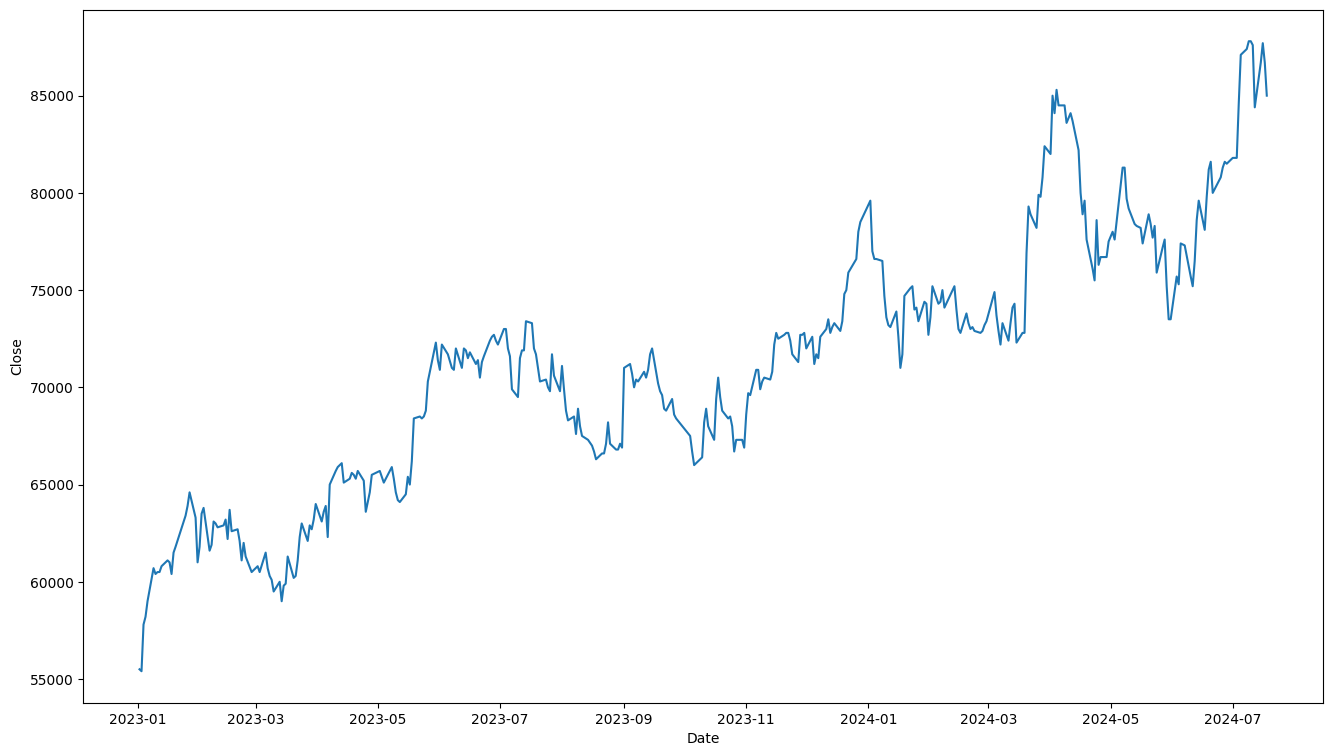

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [7]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([175, 5, 4]) torch.Size([175, 1])


In [10]:
x_train_seq

tensor([[[0.0030, 0.0030, 0.0215, 0.0811],
         [0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219]],

        [[0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471]],

        [[0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742]],

        ...,

        [[0.4018, 0.3994, 0.4202, 0.1119],
         [0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742, 0.1869],
         [0.3535, 0.3445, 0.3742, 0.1062]],

        [[0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742

In [28]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

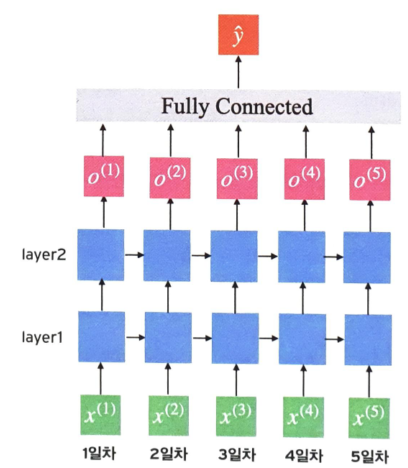

In [29]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [30]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0) # RNN 층의 Forward pass
    out = out.reshape(out.shape[0], -1) # fully connected layer에 맞게 출력 형태 변환
    out = self.fc(out) # 최종 예측값 계산
    return out

In [31]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [32]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [33]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0197
[epoch : 10] loss: 0.0019
[epoch : 20] loss: 0.0016
[epoch : 30] loss: 0.0014
[epoch : 40] loss: 0.0014


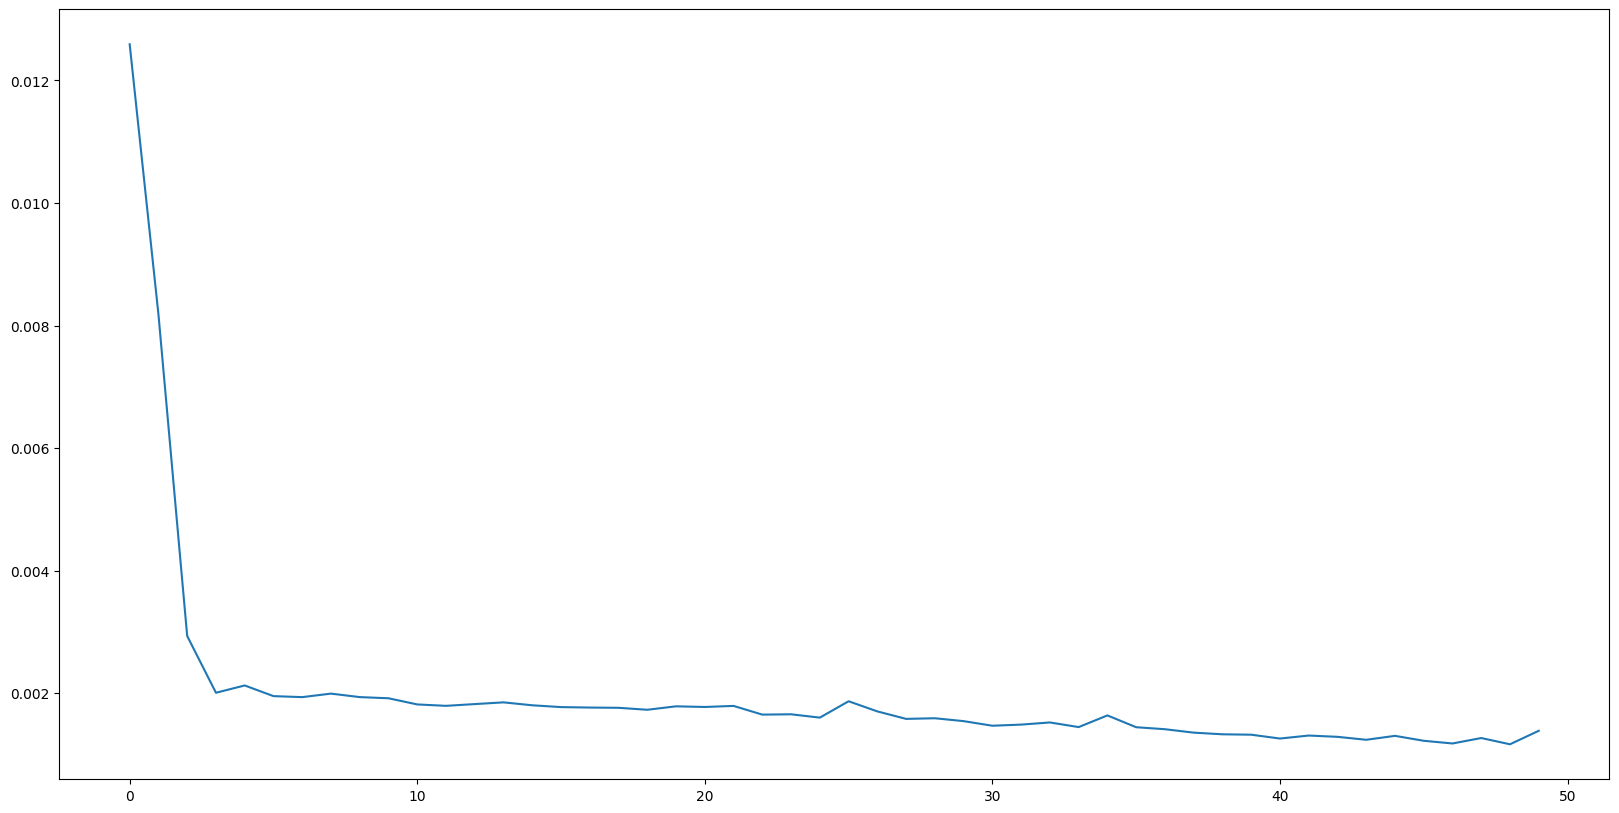

In [17]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [18]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

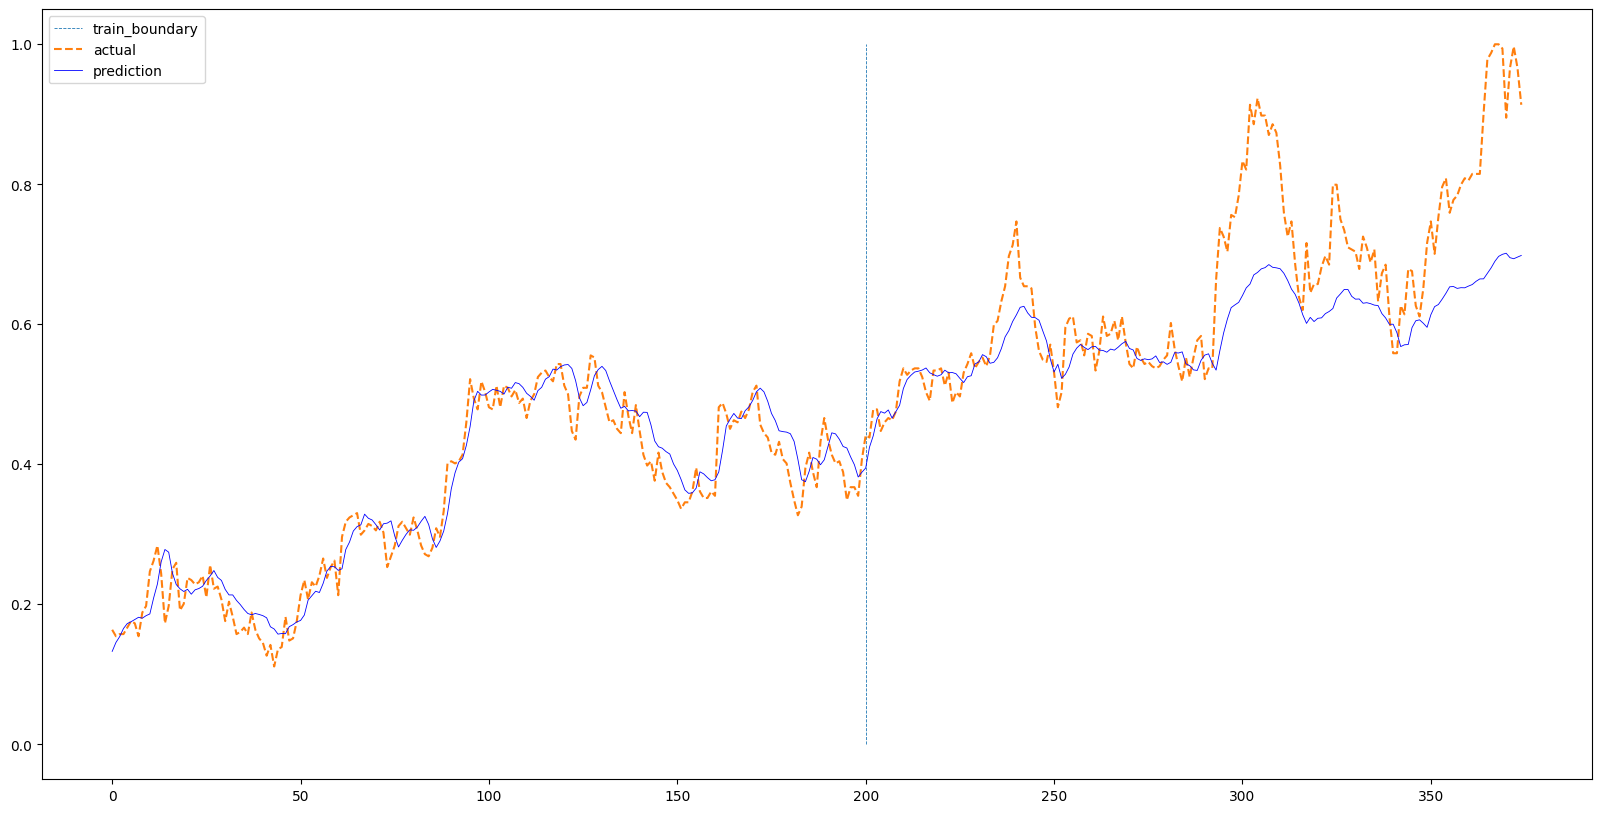

In [19]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [20]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True) # LSTM layer: 입력 시퀀스를 처리하고 은닉 상태와 셀 상태를 반환
    self.fc = nn.Linear(hidden_size*sequence_length ,1) #  # Fully connected layer: LSTM 층의 출력을 받아 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기값 0
    out, _ = self.lstm(x,(h0,c0)) # LSTM 순전파
    out = out.reshape(out.shape[0], -1) # fully connected layer에 맞게 출력 형태 변환
    out = self.fc(out) # fully connected layer 통해 최종 예측값 계산
    return out

In [22]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [23]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1330
[epoch: 10] loss: 0.0019
[epoch: 20] loss: 0.0019
[epoch: 30] loss: 0.0018
[epoch: 40] loss: 0.0016


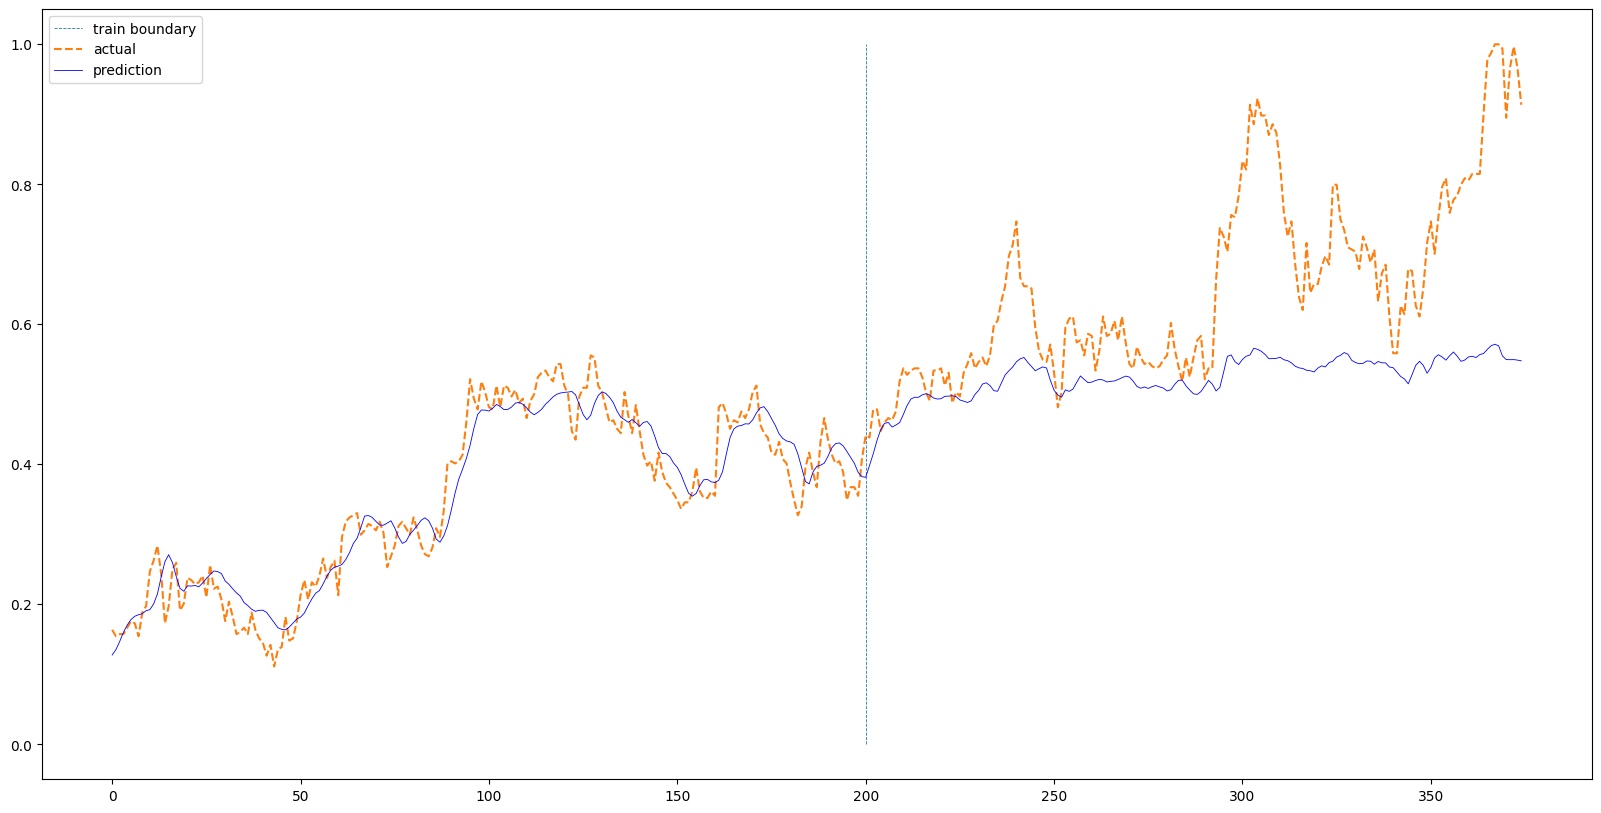

In [25]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2023-01-01', '2024-12-31')
df.tail